# Eigenpair tracking demonstration on a high-dimensional matrix path

This notebook tracks eigenpairs along a 20-dimensional matrix path and compares correction strategies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from eigenpairflow import eigenpairtrack
from eigenpairflow.correction import ogita_aishima_refinement
from eigenpairflow.ode import symmetric_ode_derivative


## Problem setup

Construct a matrix path $A(t)$ by linearly interpolating two random symmetric matrices $A_0$ and $A_1$.

In [2]:
n = 20
np.random.seed(0)
Q0, _ = np.linalg.qr(np.random.randn(n, n))
Q1, _ = np.linalg.qr(np.random.randn(n, n))

# flip eigenvalues to create crossings
eigvals0 = np.linspace(1, n, n)
eigvals1 = eigvals0[::-1]

A0 = Q0 @ np.diag(eigvals0) @ Q0.T
A1 = Q1 @ np.diag(eigvals1) @ Q1.T

def A_func(t):
    """Return the interpolated symmetric matrix A(t)."""
    return (1 - t) * A0 + t * A1

def dA_func(t):
    """Return the derivative of A(t) with respect to t."""
    return A1 - A0

t_eval = np.linspace(0, 1, 20)


## Tracking with solve_ivp

In [3]:
start = time()
results_none = eigenpairtrack(
    A_func,
    dA_func,
    (0.0, 1.0),
    t_eval,
    correction_method=None,
)
elapsed_none = time() - start


## Matching + solve_ivp correction

In [4]:
start = time()
results_match = eigenpairtrack(
    A_func,
    dA_func,
    (0.0, 1.0),
    t_eval,
    correction_method="matching",
)
elapsed_match = time() - start


## Ogita-Aishima + solve_ivp correction

In [5]:
start = time()
results_ogita = eigenpairtrack(
    A_func,
    dA_func,
    (0.0, 1.0),
    t_eval,
    correction_method="ogita_aishima",
)
elapsed_ogita = time() - start


In [6]:
start = time()

def track_with_ogita_only(A_func, dA_func, t_eval):
    """Track eigenpairs using only the Ogita-Aishima method with a forward Euler predictor."""
    Qs = []
    Ds = []
    t_prev = t_eval[0]
    A_prev = A_func(t_prev)
    eigvals0, Q0 = np.linalg.eigh(A_prev)
    idx = np.argsort(eigvals0)
    Q_prev = Q0[:, idx]
    D_prev = np.diag(eigvals0[idx])
    Qs.append(Q_prev)
    Ds.append(D_prev)
    n = A_prev.shape[0]
    y_prev = np.concatenate([Q_prev.flatten(), np.diag(D_prev)])
    for t in t_eval[1:]:
        dt = t - t_prev
        if np.all(np.isfinite(y_prev)):
            try:
                dydt = symmetric_ode_derivative(t_prev, y_prev, n, dA_func)
                y_pred = y_prev + dt * dydt
                Q_hat = y_pred[: n * n].reshape((n, n))
            except Exception:
                Q_hat = Q_prev
        else:
            Q_hat = Q_prev
        if not np.all(np.isfinite(Q_hat)):
            Q_hat = Q_prev
        A_t = A_func(t)
        Q_prev, D_prev = ogita_aishima_refinement(A_t, Q_hat)
        Qs.append(Q_prev)
        Ds.append(D_prev)
        t_prev = t
        y_prev = np.concatenate([Q_prev.flatten(), np.diag(D_prev)])
    return Qs, Ds

Qs_ogita_only, Ds_ogita_only = track_with_ogita_only(A_func, dA_func, t_eval)
elapsed_ogita_only = time() - start


## Error and runtime comparison

solve_ivp: 25.80s, L1 error 5.45e-11
Matching + solve_ivp: 24.82s, L1 error 1.78e-13
Ogita-Aishima + solve_ivp: 26.84s, L1 error 9.45e-14
Ogita-Aishima + Euler: 0.12s, L1 error 1.16e-13


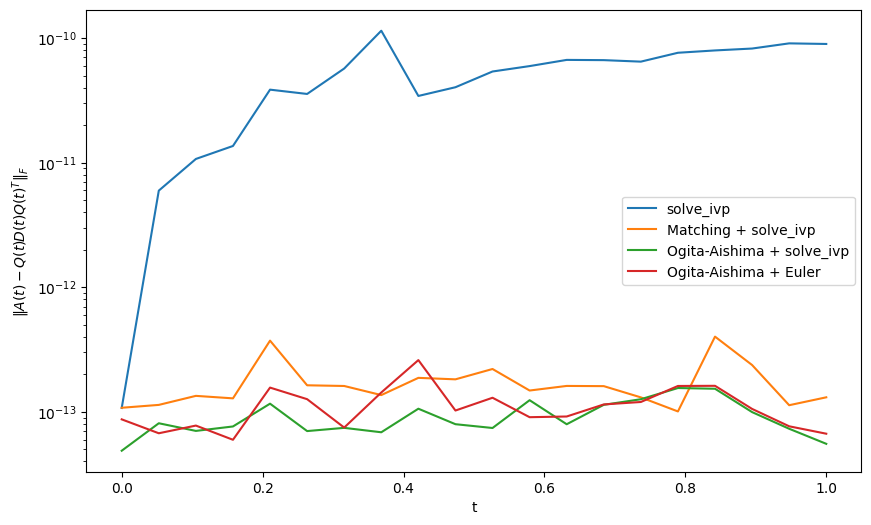

In [7]:
norm_errors_ogita_only = []
for t, Q, D in zip(t_eval, Qs_ogita_only, Ds_ogita_only):
    A_t = A_func(t)
    norm_errors_ogita_only.append(np.linalg.norm(A_t - Q @ D @ Q.T, 'fro'))

err_none = np.trapz(results_none.norm_errors, results_none.t_eval)
err_match = np.trapz(results_match.norm_errors, results_match.t_eval)
err_ogita = np.trapz(results_ogita.norm_errors, results_ogita.t_eval)
err_ogita_only = np.trapz(norm_errors_ogita_only, t_eval)

print(f'solve_ivp: {elapsed_none:.2f}s, L1 error {err_none:.2e}')
print(f'Matching + solve_ivp: {elapsed_match:.2f}s, L1 error {err_match:.2e}')
print(f'Ogita-Aishima + solve_ivp: {elapsed_ogita:.2f}s, L1 error {err_ogita:.2e}')
print(f'Ogita-Aishima + Euler: {elapsed_ogita_only:.2f}s, L1 error {err_ogita_only:.2e}')

plt.figure(figsize=(10,6))
plt.plot(results_none.t_eval, results_none.norm_errors, label='solve_ivp')
plt.plot(results_match.t_eval, results_match.norm_errors, label='Matching + solve_ivp')
plt.plot(results_ogita.t_eval, results_ogita.norm_errors, label='Ogita-Aishima + solve_ivp')
plt.plot(t_eval, norm_errors_ogita_only, label='Ogita-Aishima + Euler')
plt.yscale('log')
plt.xlabel('t')
plt.ylabel(r'$\|A(t) - Q(t)D(t)Q(t)^T\|_F$')
plt.legend()
plt.show()
